In [2]:
import numpy as np
import pandas as pd
from numpy.linalg import norm
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin

# Problem 1
NOTE: I added 3 lines to the movie ratings, 2 by friends and then my own ratings

In [3]:
def nmf_phi(A,W,H):
    return 0.5 * norm(A-W@H,ord='fro')**2

def kmeans(A,k, iters=1e4):
    def create_W(W_flat):
        W = np.zeros((n,k))
        for i in range(len(W_flat)):
            W[i,W_flat[i]] = 1
        return W
    
    def label_points(A, H):
        #return pairwise_distances_argmin(A,H)
        return np.array([np.argmin(norm(a-H,axis=1)) for a in A])
    
    iters = int(iters)
    n,d = A.shape
    
    H = A[np.random.permutation(n)[:k]]
    W_flat = label_points(A, H)
    
    losses = np.zeros(iters+1)
    losses[0] = nmf_phi(A,create_W(W_flat),H)
    
    for i in range(1, iters+1):
        H = np.array([A[W_flat==j].mean(axis=0) for j in range(k)])
        W_flat = label_points(A,H)
        losses[i] = nmf_phi(A,create_W(W_flat),H)
    return create_W(W_flat), H, losses
        

def nmf_pgd(A,k, W=None,H=None,iters = 1e4, alpha = 1e-3):
    iters = int(iters)
    n,d = A.shape
    if W is None:
        W = np.random.uniform(size=(n,k))
    if H is None:
        H = np.random.uniform(low=1,high=5,size=(k,d))
    
    losses = np.zeros(iters + 1)
    losses[0] = nmf_phi(A,W,H)
    
    for i in range(1,iters+1):
        R = A - W @ H
        W,H = np.maximum(W + alpha * R @ H.T,0), np.maximum(H + alpha * W.T@R,0)
        losses[i] = nmf_phi(A,W,H)
        
    return W, H, losses

def nmf_ls(A, k, W=None, H=None, iters = 1e4):
    iters = int(iters)
    n,d = A.shape
    if W is None:
        W = np.random.uniform(size=(n,k))
    if H is None:
        H = np.random.uniform(low=1,high=5,size=(k,d))
    
    losses = np.zeros(iters + 1)
    losses[0] = nmf_phi(A,W,H)
    
    # UPDATE SCHEME
    for i in range(1,iters+1):
        W,H = W*(A@H.T)/(W@H@H.T), H*(W.T@A)/(W.T@W@H)
        #W = W*(A@H.T)/(W@H@H.T)
        #H = H*(W.T@A)/(W.T@W@H)
        losses[i] = nmf_phi(A,W,H)
        
    return W, H, losses

def nmf_pgd_ls(A,k,W=None,H=None,iters=1e4,split=0.9,pgd_alpha=1e-3):
    iters = int(iters)
    n,d = A.shape
    if W is None:
        W = np.random.uniform(size=(n,k))
    if H is None:
        H = np.random.uniform(low=1,high=5,size=(k,d))
    
    iters_pgd = int(iters * split)
    iters_ls = iters - iters_pgd
    
    W, H, losses_pgd = nmf_pgd(A,k, W=W,H=H,iters = iters_pgd, alpha = pgd_alpha)
    W, H, losses_ls = nmf_ls(A, k, W=W, H=H, iters = iters_ls)
    return W, H, np.concatenate((losses_pgd,losses_ls[1:]))

In [4]:
A = pd.read_csv('dataset1/MovieRankings36.csv', delimiter=',', header=None)
A_submatrix = A.drop(A.columns[[0,2,7,9,12,13,14,15,16,18,19]], axis=1)
A_submatrix = A_submatrix[~np.isnan(A_submatrix).any(axis=1)].to_numpy()

In [14]:
k = 5
_,_,losses_km = kmeans(A_submatrix,k)
_,_,losses_pgd = nmf_pgd(A_submatrix,k,alpha=1e-4)
_,_,losses_ls = nmf_ls(A_submatrix,k)
_,_,losses_pgd_ls = nmf_pgd_ls(A_submatrix,k,pgd_alpha=1e-4)

# Problem 2

In [16]:
def mc_lrf(A,omega,k,l, X=None, Y=None, iters=1e4):
    iters = int(iters)
    n,d = A.shape
    
    def mc_lrf_phi(X,Y):
        return 0.5 * norm(omega*(A-X@Y.T),ord='fro')**2 + l/2*(norm(X,ord='fro')**2 + norm(Y,ord='fro')**2)
    
    def tikhonov_solver(X,b):
        _,d_ts = X.shape
        return np.linalg.solve(X.T@X + l**2 * np.eye(d_ts),X.T@b)
    
    if X is None:
        X = np.random.normal(size=(n,k))
    if Y is None:
        Y = np.random.normal(size=(d,k))
    
    losses = np.zeros(iters+1)
    losses[0] = mc_lrf_phi(X,Y)
    
    for i in range(1,iters+1):
        #iterate for X
        for i in range(n):
            omega_i = np.array([j for j in range(d) if omega[i,j] == 1])
            X[i] = tikhonov_solver(Y[omega_i],A[i,omega_i])
        
        #iterate for Y
        for j in range(d):
            omega_j = np.array([i for i in range(n) if omega[i,j] == 1])
            Y[j] = tikhonov_solver(X[omega_j],A[omega_j,j])
        
        losses[i] = mc_lrf_phi(X,Y)
    return X,Y,losses

def mc_nnt(A,omega,l, M=None, iters=1e4):
    def mc_nnt_phi(M):
        return 0.5 * norm(omega * (A-M), ord='fro')**2 + norm(M,ord='nuc')
    
    def S_l(X):
        U, S, Vh = np.linalg.svd(X,full_matrices=False,compute_uv=True)
        return U @ np.diag(np.maximum(S-l,0)) @ Vh
        
    iters = int(iters)
    n,d = A.shape
    
    if M is None:
        M = np.random.uniform(low=1,high=5,size=(n,d))
    
    losses = np.zeros(iters+1)
    losses[0] = mc_nnt_phi(M)
    
    for i in range(1, iters+1):
        M = S_l(M + omega * (A-M))
        losses[i] = mc_nnt_phi(M)
    return M, losses

In [17]:
A = pd.read_csv('dataset1/MovieRankings36.csv', delimiter=',', header=None)
omega = 1.0 * A.notna().to_numpy()
A_complete = A.fillna(0).to_numpy()

In [18]:
k = 10
l = 1

X_lrf,Y_lrf, losses_lrf = mc_lrf(A_complete, omega, k, l)
M_lrf = X_lrf @ Y_lrf.T

M_nnt, losses_nnt = mc_nnt(A_complete, omega, l)

# Problem 3

In [19]:
def CUR(A, c, r, k):
    def column_select(A,c):
        n,d = A.shape
        _, _, Vh = np.linalg.svd(A,full_matrices=False,compute_uv=True)
        V_k = Vh[:k].T
        pi = np.array([norm(v_i)**2/k for v_i in V_k])
        
        columns = []
        # NOTE: didn't implement scaling
        # - why does it matter
        # - should it not be max instead of min
        for j in range(d):
            if np.random.uniform() <= min(1,c*pi[j]):
                columns.append(j)
        return A[:,columns]
    
    C = column_select(A,c)
    R = column_select(A.T,r).T
    U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    return C, U, R

In [20]:
M = pd.read_csv('dataset2/M.csv', delimiter=',', header=None).to_numpy()

In [ ]:
k_list = np.arange(2,11)
a_list = np.arange(1,9)
runs = 100

ratio = np.zeros((len(k_list),len(a_list)))
trunc_svd_norm = np.zeros(len(k_list))

U_M, S_M, Vh_M = np.linalg.svd(M,full_matrices=False,compute_uv=True)

for i_k in range(len(k_list)):
    k = k_list[i_k]
    print("Working on k={}".format(k))

    M_k = U_M[:,:k] @ np.diag(S_M[:k]) @ Vh_M[:k,:]
    trunc_svd_norm[i_k] = norm(M-M_k, ord='fro')
    
    for i_a in range(len(a_list)):
        a = a_list[i_a]
        print("\tWorking on a={}".format(a))
        
        for i_run in range(runs):
            C, U, R = CUR(M, a*k, a*k, k)
            ratio[i_k,i_a] += norm(M-C@U@R, ord='fro') / trunc_svd_norm[i_k]
        ratio[i_k,i_a] /= runs

# Problem 4

In [21]:
M = pd.read_csv('dataset2/M.csv', delimiter=',', header=None).to_numpy()
y = pd.read_csv('dataset2/y.csv', delimiter=',', header=None).to_numpy().flatten()

In [26]:
# Difference in percentage appearances stratified by y
def stratify_percent_scores(M,y):
    indicator = M>0
    counts_pos = indicator[y==1].mean(axis=0)
    counts_neg = indicator[y==-1].mean(axis=0)
    return np.abs(counts_pos-counts_neg)

# Difference in leverage score stratified by y
def stratify_leverage_scores(M,y):
    pos = M[y==1]
    neg = M[y==-1]
    pos_lev_scores = leverage_scores(pos)
    neg_lev_scores = leverage_scores(neg)
    return np.abs(pos_lev_scores-neg_lev_scores)

# Count of number of unique appearances
def count_scores(M):
    return (M > 0).sum(axis=0)

# Leverage score
def leverage_scores(M):
    _, _, Vh = np.linalg.svd(M,full_matrices=False,compute_uv=True)
    return np.array([norm(v_i)**2 for v_i in Vh.T])

# Leverage score of M normalized by wordcount/article
def normalized_scores(M):
    sums = M.sum(axis=1)
    percents = M/sums[:,None]
    return leverage_scores(percents)

def get_max_k_scores(scores, k):
    return scores.argsort()[-k:][::-1]

def plot_svd_projection(M,y,top_5=False):
    X = M.copy()
    if top_5:
        top_5_leverage_scores = get_max_k_scores(leverage_scores(X), 5)
        X = X[:,top_5_leverage_scores]
    _, _, Vh = np.linalg.svd(X,full_matrices=False,compute_uv=True)
    x_1 = X@Vh[0,:]
    x_2 = X@Vh[1,:]
    
    plt.figure(figsize=(20,8))
    plt.scatter(x_1[y==1],x_2[y==1],c='red')
    plt.scatter(x_1[y==-1],x_2[y==-1],c='blue')
    plt.show()

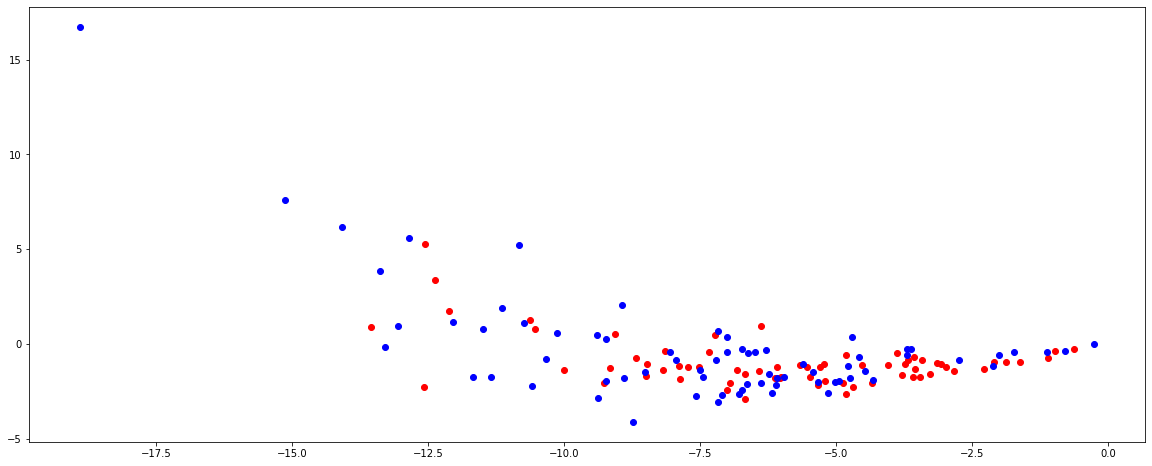

In [27]:
k = 10000
a = 3 #WHAT IS THIS !?!?!??!

scores = stratify_leverage_scores(M,y)
selected_columns = get_max_k_scores(scores, k)

M_subset = M[:,selected_columns]
plot_svd_projection(M_subset,y,False)